# Generating heightmaps

Heightmaps are a category of Gazebo geometries that allow the representation of a large ground plane using a gray scale image to describe its topography.
The images should have a size of `[2*n + 1, 2*n + 1]`, `n` being an integer.

This examples below show how to use the `HeightmapGenerator` class to generate heightmaps from noise functions and custom gray scale images.

It also shows how to apply masks in order to select regions of interest on the original heightmap image.

Lastly, the last section shows how to generate a Gazebo model to be stored in the `$HOME/.gazebo/models` folder to load the model in Gazebo

See this [notebook](gen_add_texture_to_heightmap.ipynb) to see how to work with heightmap textures.

Go to this [link](http://sdformat.org/spec?ver=1.7&elem=geometry#geometry_heightmap) to see the SDF documentation on heightmaps.


In [2]:
import os
import trimesh
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import random_shapes
from skimage.util import invert
from pcg_gazebo.generators import HeightmapGenerator

# Create a heightmap generator
hg = HeightmapGenerator(
    map_size=[10, 10, 1])

## Create heightmaps from noise functions

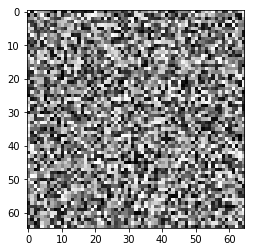

In [3]:
hg.reset()
hg.add_random_layer()
hg.show()

In [4]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

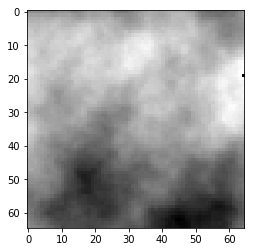

In [5]:
hg.reset()
hg.add_perlin_noise_layer(freq=10.0, octaves=10)
hg.show()

In [6]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

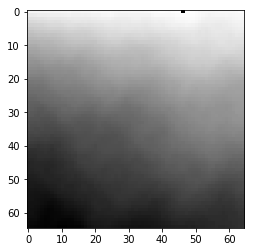

In [7]:
hg.reset()
hg.add_simplex_noise_layer(freq=100.0, octaves=10)
hg.show()

In [8]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

Combine all three noise layers

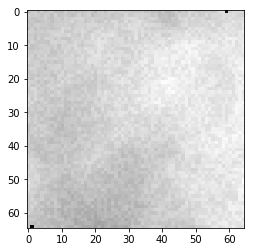

In [9]:
hg.reset()
hg.add_random_layer(min_value=0, max_value=0.1)
hg.add_perlin_noise_layer(freq=110.0, octaves=10)
hg.add_simplex_noise_layer(freq=150.0, octaves=10)
hg.show()

In [10]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

In [11]:
print(hg.heightmap.to_sdf())

2020-09-08 17:20:54,421 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/junchuan/.pcg, dir=None


Lossy conversion from float64 to uint8. Range [22.0, 340.0]. Convert image to uint8 prior to saving to suppress this warning.


line 111.
line 111.
<heightmap>
  <uri>file:///home/junchuan/.pcg/materials/textures/heightmap.png</uri>
  <use_terrain_paging>0</use_terrain_paging>
  <size>10 10 1</size>
  <sampling>2</sampling>
  <pos>0 0 0</pos>
</heightmap>



## Adding a mask

Masks are images with pixels within the range `[0, 1]` that will be multiplied by the heightmap layer.

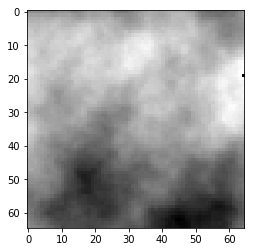

In [12]:
# Create a heightmap generator
hg = HeightmapGenerator(
    map_size=[10, 10, 5])

# Add a Perlin noise layer
hg.add_perlin_noise_layer(freq=10.0, octaves=10)
hg.show()

In [13]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

In [14]:
# Create a circular mask
image = np.zeros(hg.image_size)
rr, cc = disk((20, 20), 15)

image[rr, cc] = 1
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

NameError: name 'disk' is not defined

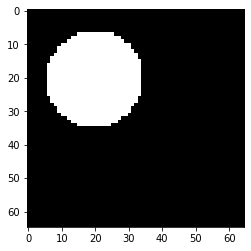

True

In [14]:
hg.add_custom_mask(image)
hg.show_mask()

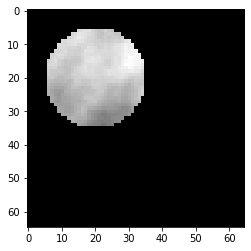

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(hg.heightmap.image, cmap='gray')

In [16]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

# Generating heightmaps from shapes

(65, 65)


Text(0.5, 1.0, 'Grayscale shapes')

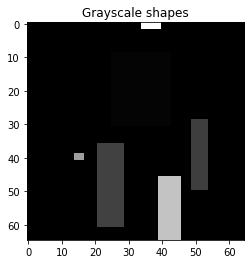

In [17]:
# Size of the heightmap image
image_size = [2**6 + 1, 2**6 + 1]

# Let's start simple and generate a 128x128 image
# with a single grayscale rectangle.
result = random_shapes(image_size, max_shapes=10, shape='rectangle',
                       multichannel=False, random_seed=0)

image, labels = result
print(image.shape)

# Invert colors
image = invert(image)

# We can visualize the images.
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')
ax.set_title('Grayscale shapes')

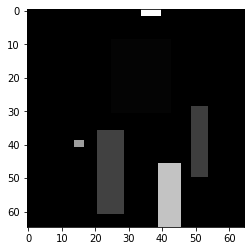

In [18]:
# Create a heightmap generator
hg = HeightmapGenerator(
    image_size=image_size,
    map_size=[10, 10, 5])

hg.add_custom_layer(image)

hg.show()

In [19]:
scene = trimesh.Scene([hg.heightmap.mesh.mesh])
scene.show()

## Export as Gazebo model

In [20]:
model = hg.as_model()

# First a preview of the SDF file (paths to the heightmap files
# must be changed when a Gazebo model folder is created)
print(model.to_sdf())

2020-07-10 16:16:15,510 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None


Lossy conversion from float64 to uint8. Range [0.0, 246.0]. Convert image to uint8 prior to saving to suppress this warning.


2020-07-10 16:16:15,529 | WARNING | heightmap | Input resources folder to store heightmaps does not exist, using the default /home/mam0box/.pcg, dir=None
<model name="heightmap">
  <pose frame="">0 0 0 0 -0 0</pose>
  <static>0</static>
  <self_collide>0</self_collide>
  <allow_auto_disable>0</allow_auto_disable>
  <link name="link">
    <kinematic>0</kinematic>
    <gravity>1</gravity>
    <self_collide>0</self_collide>
    <collision name="collision">
      <geometry>
        <heightmap>
          <uri>file:///home/mam0box/.pcg/materials/textures/heightmap.png</uri>
          <size>10 10 5</size>
          <pos>0 0 0</pos>
          <use_terrain_paging>0</use_terrain_paging>
          <sampling>2</sampling>
        </heightmap>
      </geometry>
      <pose frame="">0 0 0 0 -0 0</pose>
    </collision>
    <visual name="visual">
      <geometry>
        <heightmap>
          <uri>file:///home/mam0box/.pcg/materials/textures/heightmap.png</uri>
          <size>10 10 5</size>
         

In [21]:
model.name = 'pcg_test_heightmap'
model_path = model.to_gazebo_model(copy_resources=True, overwrite=True)

print('Gazebo model stored at: {}'.format(model_path))

print('List of files in {}: {}'.format(model_path, os.listdir(model_path)))
print('List of files in {}: {}'.format(os.path.join(model_path, 'materials', 'textures'), os.listdir(os.path.join(model_path, 'materials', 'textures'))))

2020-07-10 16:16:15,548 | WARNING | model | Another model <pcg_test_heightmap> was found at /home/mam0box/.gazebo/models/pcg_test_heightmap
Gazebo model stored at: /home/mam0box/.gazebo/models/pcg_test_heightmap
List of files in /home/mam0box/.gazebo/models/pcg_test_heightmap: ['materials', 'model.config', 'model.sdf']
List of files in /home/mam0box/.gazebo/models/pcg_test_heightmap/materials/textures: ['pcg_test_heightmap_link_collision', 'pcg_test_heightmap_link_collision.png']
